In [1]:
import json
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from sklearn import linear_model, metrics, decomposition
import pprint
%matplotlib inline

In [2]:
df = pd.read_csv('cleaned_data.csv', index_col='Respondent')
with open('column_mapping.json', 'r') as f:
    column_mapping = json.load(f)

In [3]:
row_drop_mask = ((df['YearsProgram'].isnull() & df['YearsCodedJob'].isnull()) |
                 (df['CareerSatisfaction'].isnull()) |
                 (df['JobSatisfaction'].isnull()) |
                 (df['YearsCodedJobPast'].notnull()))
rows_to_drop = df[row_drop_mask].index
df.drop(index=rows_to_drop, inplace=True)

In [4]:
cols_to_drop = []
for col in df.columns:
    if not col.startswith('Country_'):
        continue
    num_from_country = df[col].sum()
    if num_from_country < 10:
        cols_to_drop.append(col)

cols_to_drop += ['ExpectedSalary', 'StackOverflowSatisfaction', 'HoursPerWeek', 'YearsCodedJobPast']
df.drop(columns=cols_to_drop, inplace=True)

In [5]:
rows_with_no_YearsProgram = df[df['YearsProgram'].isnull()].index
df.loc[rows_with_no_YearsProgram, 'YearsProgram'] = df.loc[rows_with_no_YearsProgram, 'YearsCodedJob']
df.loc[df['YearsCodedJob'].isnull(), 'YearsCodedJob'] = 0

In [6]:
RegressionResult = namedtuple('RegressionResult', ['mse', 'coefficients'])

In [28]:
def regression(df, plot=True):
    train = df.sample(frac=0.9)
    train_without_salary = train.drop(columns='Salary')
    test = df.drop(train.index)
    test_without_salary = test.drop(columns='Salary')
    
    reg = linear_model.LinearRegression()
    reg.fit(train_without_salary, train['Salary'])
    coeffs = dict(zip(train_without_salary.columns, reg.coef_))
    
    predictions = reg.predict(test_without_salary)
    errors = predictions - test['Salary'].values
    if plot:
        plt.hist(errors, bins=20)
        plt.show()
    
    mse = metrics.mean_squared_error(test['Salary'], predictions)
    return RegressionResult(mse=mse, coefficients=coeffs)

def ten_fold_mse(df):
    shuffled_df = df.loc[np.random.permutation(df.index)]
    mse_sum = 0
    
    for i in range(10):
        test = shuffled_df.iloc[int(len(df) * i/10): int(len(df) * (i+1)/10)]
        test_without_salary = test.drop(columns='Salary')
        train = shuffled_df.drop(test.index)
        train_without_salary = train.drop(columns='Salary')
        
        reg = linear_model.LinearRegression()
        reg.fit(train_without_salary, train['Salary'])
        predictions = reg.predict(test_without_salary)
        mse = metrics.mean_squared_error(test['Salary'], predictions)
        print(mse)
        mse_sum += mse
        
    return mse_sum / 10;

In [8]:
blind_guess_train = df.sample(frac=0.9)
blind_guess_test = df.drop(blind_guess_train.index)
blind_guess_prediction = np.full(len(blind_guess_test), np.mean(blind_guess_train['Salary']))
mse_blind_guess = metrics.mean_squared_error(blind_guess_test['Salary'], blind_guess_prediction)
mse_blind_guess**0.5

39024.54077038398

In [9]:
def keep_columns(df, original_columns_to_keep):
    cleaned_columns_to_keep = []
    for original_col in original_columns_to_keep:
        cleaned_columns = column_mapping[original_col]
        for cleaned_col in cleaned_columns:
            if cleaned_col not in cols_to_drop:
                cleaned_columns_to_keep.append(cleaned_col) 
    return df[cleaned_columns_to_keep + ['Salary']].dropna()

In [10]:
results_by_col = {}
for original_column in column_mapping:
    if original_column == 'Salary' or original_column in cols_to_drop:
        continue
    result = regression(keep_columns(df, [original_column]), plot=False)
    results_by_col[original_column] = result

In [11]:
most_correlated_inputs = sorted(results_by_col.keys(), key=lambda c: results_by_col[c].mse)

In [12]:
for input_var in most_correlated_inputs:
    print('{}: {}'.format(input_var, results_by_col[input_var].mse**0.5))

Country: 27130.86139457427
Currency: 30284.452902015724
YearsCodedJob: 34612.65378072277
YearsProgram: 35341.257771301556
HaveWorkedDatabase: 37302.27654408591
SelfTaughtTypes: 37619.44431834588
CompanyType: 37725.53016684814
ImportantHiringCommunication: 37842.10678630998
ShipIt: 37918.03764808058
IDE: 37985.04479239763
Methodology: 37985.54091854482
CousinEducation: 38128.75144901967
VersionControl: 38186.067077977794
InfluenceTechStack: 38286.592396121
CareerSatisfaction: 38356.31307584043
MetricAssess: 38401.73212509786
WantWorkLanguage: 38413.83036333459
AssessJobCommute: 38418.40589013951
WantWorkDatabase: 38458.43266132165
DiversityImportant: 38585.22303067465
CompanySize: 38589.192453090276
JobProfile: 38613.278881904844
ImportantBenefits: 38622.86571013643
StackOverflowDevices: 38626.32123491373
StackOverflowCompanyPage: 38690.23629705413
InfluenceDeptTech: 38706.941331693866
FriendsDevelopers: 38719.93138854421
HaveWorkedPlatform: 38756.36028909408
DeveloperType: 38757.178066

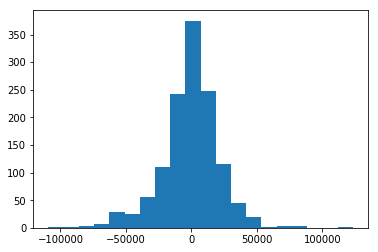

22123.578902071327

In [13]:
predictors = ['Country', 'Currency', 'YearsCodedJob']
res1 = regression(keep_columns(df, predictors))
res1.mse**0.5

In [14]:
# n_questions = list(range(1, 50))
# mses = []
# for n in n_questions:
#     result = ten_fold_mse(keep_columns(df, most_correlated_inputs[:n]))
#     mses.append(result)
#     if n % 5 == 0: print(n)

# plt.figure(figsize=(4, 3))
# plt.plot(mses[:39] + mses[40:])
# plt.xlabel('Number of questions used to train model')
# plt.ylabel('Mean-squared-error of salary')

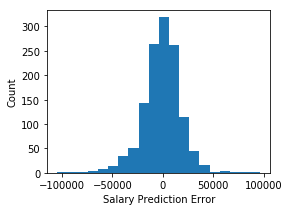

In [15]:
plt.figure(figsize=(4, 3))
plt.xlabel('Salary Prediction Error')
plt.ylabel('Count')
all_predictor_cols = [col for col in column_mapping.keys() if col != 'Salary']
all_questions_result = regression(keep_columns(df, all_predictor_cols))

In [16]:
all_questions_result.coefficients

{'.NET Core': -928574461906086.5,
 'Agile': 1004.2197393344923,
 'Amazon Web Services (AWS)': -1236487180634654.5,
 'Android': 8834307533382222.0,
 'Android Studio': -262.4082934209514,
 'Android app': -607.1225951632641,
 'Android browser': -338.43143439539745,
 'AngularJS': -575409552343806.1,
 'AnnoyingUI_Agree': 327.5102592321234,
 'AnnoyingUI_Disagree': 1652.932041416805,
 'AnnoyingUI_Somewhat agree': -482.73513130757544,
 'AnnoyingUI_Strongly agree': 146.1373869418601,
 'AnnoyingUI_Strongly disagree': -3003.975317509608,
 'Annual bonus': 2183.936355927774,
 'Arduino': -358183832745985.0,
 'Assembly': 799779111222607.2,
 'AssessJobCommute_Important': -9940.636795085236,
 'AssessJobCommute_Not at all important': -10857.940891997172,
 'AssessJobCommute_Not very important': -9741.044839110315,
 'AssessJobCommute_Somewhat important': -10556.45692605573,
 'AssessJobCommute_Very important': -9677.60938032163,
 'AssessJobCompensation_Important': -705.1392673844821,
 'AssessJobCompensatio

In [29]:
all_cols_10fold_mse = ten_fold_mse(keep_columns(df, all_predictor_cols))
all_cols_10fold_mse

399708358.49800295
384263049.9556365
398243457.22200346
408897408.22583586
394381197.68664044
372908322.8835387
331157199.966214
436680343.6860606
396489639.3779347
378637198.3239414


390136617.58258086

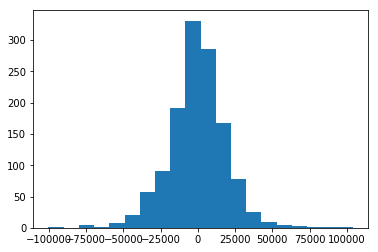

19469.079936335493

In [18]:
PCA = decomposition.PCA()
df_without_salary = df.drop(columns='Salary') 
PCA.fit(df_without_salary)
pca_ndarray = PCA.transform(df_without_salary)
pca_cols = ['PC{}'.format(i) for i in range(len(df_without_salary.columns))]
pca_df = pd.DataFrame(pca_ndarray, index=df.index, columns=pca_cols)
pca_df['Salary'] = df['Salary']
pca_reg = regression(pca_df)
pca_reg.mse**0.5

In [19]:
results_by_pc = {}
for principal_component in pca_df.drop(columns='Salary').columns:
    result = regression(pca_df[[principal_component, 'Salary']], plot=False)
    results_by_pc[principal_component] = result

In [20]:
most_correlated_pcs = sorted(results_by_pc.keys(), key=lambda pc: results_by_pc[pc].mse)

In [21]:
for principal_component in most_correlated_pcs:
    print('{}: {}'.format(principal_component, results_by_pc[principal_component].mse**0.5))

PC0: 35610.15313552551
PC847: 37357.26362624698
PC872: 37721.372517746764
PC752: 37721.681909866296
PC200: 37812.82072357236
PC201: 37840.02631690747
PC57: 37841.36471675745
PC569: 37901.749708788906
PC242: 37989.372639301306
PC289: 38074.56481232867
PC664: 38130.35584749677
PC309: 38150.74022342472
PC599: 38179.55352334161
PC357: 38200.12662078709
PC131: 38225.261490531266
PC20: 38238.31629227007
PC674: 38261.35187601849
PC113: 38290.34407540571
PC26: 38299.04184203091
PC272: 38313.21881277358
PC559: 38320.43432118294
PC949: 38356.59659306225
PC102: 38368.455190532186
PC623: 38380.43639545692
PC505: 38382.91753492329
PC545: 38400.05980961778
PC921: 38406.03529660652
PC576: 38408.194946774
PC888: 38411.8456537745
PC830: 38413.22709414552
PC563: 38415.42573866267
PC371: 38416.652120383784
PC319: 38420.450382687704
PC575: 38469.28322330203
PC835: 38472.350606730455
PC344: 38473.65287305224
PC41: 38476.59178820435
PC24: 38478.563180305886
PC771: 38485.8764401226
PC471: 38487.64860223028
P

In [22]:
npcs = list(range(1, 984, 10))
pca_mses = []
for npc in npcs:
    cols = most_correlated_pcs[:npc] + ['Salary']
    result = regression(pca_df[cols], plot=False)
    pca_mses.append(result.mse**0.5)
    if ((npc - 1) % 100 == 0): print(npc)

1
101
201
301
401
501
601
701
801
901


In [23]:
cols = most_correlated_pcs + ['Salary']
result = regression(pca_df[cols], plot=False)

In [24]:
result.mse**0.5

86524978.12614664

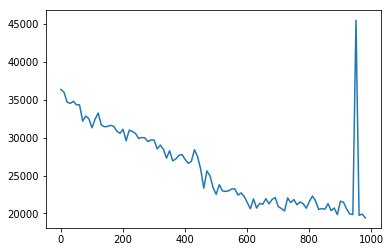

In [25]:
plt.plot(npcs, pca_mses)

In [26]:
# pca_reg_results = pd.DataFrame({'NumPrincipalComponents':npcs, 'Mse':pca_mses}).set_index('NumPrincipalComponents')
# pca_reg_results.to_csv('pca_reg_results.csv')

In [27]:
# regression(pca_df, plot=False).mse**0.5